In [196]:
import pandas as pd
import geopandas as gp
import numpy as np 
import xlrd
import os
import fiona
from statistics import mean, median
import string
import math
import re

from shapely.geometry import Polygon
from shapely.ops import cascaded_union

# VEST NE 2018

## VEST Documentation

### Sources

Election results from the Nebraska Secretary of State's office via email.

### Shapefiles

Precinct shapefiles primarily from the U.S. Census Bureau's 2020 Redistricting Data Program Phase 2 release. 

Adams, Antelope, Box Butte, Buffalo, Burt, Butler, Chase, Cherry, Cuming, Custer, Dakota, Dawes, Dawson, Deuel, Dodge, Douglas, Garfield, Hamilton, Harlan, Holt, Kearney, Keith, Keya Paha, Kimball, Lincoln, Madison, Merrick, Morrill, Nemaha, Nuckolls, Otoe, Perkins, Phelps, Platte, Red Willow, Richardson, Saline, Sarpy, Scotts Bluff, Seward, Stanton, Thayer, Valley, and Washington either used a replacement shapefile or, more often, required tweaks based on PDF maps from county election officials and the geocoded voter registration file.

Some counties reported one or more classes of votes at the county level. These were distributed by candidate based on the precinct-level reported vote.

### Races

G18USSRFIS - Deb Fischer (Republican Party)<br>
G18USSDRAY - Jane Raybould (Democratic Party)<br>
G18USSLSCH - Jim Schultz (Libertarian Party)<br>
<br>
G18GOVRRIC - Pete Ricketts (Republican Party)<br>
G18GOVDKRI - Bob Krist (Democratic Party)<br>
<br>
G18SOSREVN - Bob Evnen (Republican Party)<br>
G18SOSDDAN - Spencer Danner (Democratic Party)<br>
<br>
G18TRERMUR - John Murante (Republican Party)<br>
<br>
G18ATGRPET - Doug Peterson (Republican Party)<br>
<br>
G18AUDRJAN - Charlie Janssen (Republican Party)<br>
G18AUDDSKI - Jane Skinner (Democratic Party)<br>

## Load in VEST file

In [197]:
vest_ne_2018 = gp.read_file("../vest/ne_2018/ne_2018.shp")

<AxesSubplot:>

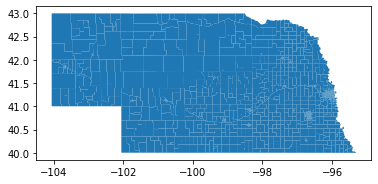

In [198]:
vest_ne_2018.plot()

## Build table of precinct-level election results from NE SOS Spreadsheets

The 2018 election results provided by NE SOS are designed for human legibility, not algorithmic use. They need to be cleaned, transformed, and reformatted to be usable here; this section outlines that process.

In [199]:
adams_xls = pd.read_excel('../raw-from-source/2018-er/General-18-Precinct-Results/Adams.xls')

Notes for parsing Excel documents:
- Each county's excel document contains many races separated by whitespace rows.
- Ignore column B; it only contains the name of the county (which we have from the filename), and creates an unnecessary blank column in the vote tables.
- When these county spreadsheets are loaded in as dataframes, their default column headings are not descriptive. To make this easier to follow, we assign them alphabetical column names that align with Excel's typical column naming conventions (Column 1 = "A", Column 2 = "B", etc.)

In [200]:
# Returns the letter at position 'num' in the English alphabet. A=1, B=2, ..., Z=26. 
def num_to_letter(num):
    return chr(ord('@') + num)

# returns a cleaned NE 2018 county spreadsheet as a dataframe. It contains the results of many races.
def load_county_excel_sheet(path_to_file):
    county_xls = pd.read_excel(path_to_file, skiprows=1)
    # assign alphabetical column names to align with Excel's standard formatting
    cols = list(map(lambda e: num_to_letter(e), range(1, len(county_xls.columns)+1)))
    county_xls.columns = cols
    # drop column B from the table
    cols.remove('B')
    county_xls = county_xls[cols]
    # drop all the blank rows (all NaN)
    county_xls = county_xls.dropna(how='all')
    county_xls = county_xls.reset_index(drop=True)
    return county_xls.copy(deep=True)

In order to separate the tables for different races in each county's spreadsheet, we need to detect where each table starts and ends. Each table starts with a row that contains something close to an office/race label (e.g., "For United States Senator"), and each table ends with a row that contains the total number of votes for each office. Throughout this section, we'll refer to the rows that contain office/race values as "office rows", and the row w/ vote totals as "total rows". 

These rows have distinguishing features that we can search for to find their locations (i.e., row numbers) in each county's spreadsheet:

`office_rows = county_xls[(county_xls['A'] == 'Precinct Name') & (~county_xls['C'].isnull())]`<br>
`total_rows = county_xls[county_xls['A'] == 'Total']`

In the code below, we use these key rows to detect the height of each table.

In [201]:
# Attempts to find the boundaries of each subtable in a county spreadsheet by looking for rows containing
# office/race information, and by looking for "total" rows. 
#
# Returns a list of tuples (s, t), one per subtable detected in county_xls. 
# s = the starting row # of the subtable
# t = the ending row # of the subtable. 
#
# This function expects that the `county_xls` dataframe has been cleaned and prepared in the 
# manner performed by the load_county_excel_sheet() function. 
#
# Raises a ValueException if there's a problem detecting boundaries. 
def detect_table_boundaries(county_xls):
    office_indices = list(county_xls[(county_xls['A'] == 'Precinct Name') & (~county_xls['C'].isnull())].index)
    total_indices = list(county_xls[county_xls['A'] == 'Total'].index)
    table_boundary_pairs = list(zip(office_indices, total_indices))
    
    # check that there are an equal number of "office" rows and total rows. 
    # If not, file is malformed and data must be extracted manually.
    if len(office_indices) != len(total_indices):
        raise ValueException('Number of office rows {0} != number of total rows {1}.'.format(len(office_indices), len(total_indices)))

    # check that there is no distance between each table. Since we've removed whitespace, distance likely means that
    # our table separation routine failed and the races will have to be separated manually.  
    for idx, pair in enumerate(table_boundary_pairs):
        if idx != len(table_boundary_pairs)-1:
            pair_next = table_boundary_pairs[idx+1]
            if pair_next[0] - pair[1] != 1:
                raise ValueException('Table boundary error detected. "Total" at row # {0}, Next "office" row at {1}'.format(pair[1], pair_next[0]))
    
    return table_boundary_pairs

The row below each "office row" is a row that we'll refer to as a "candidate row". It contains each of the candidates that are running in the race summarized by a subtable. 

This code extracts the candidate's names from a "candidate row". It removes unnecessary party affiliations, formatting characters, and gratuitous whitespace from each cell, and it returns each candidate's name as a list. It also ignores the rightmost "Total" column because we're about to remove that column entirely; keeping it just makes things more complicated, and we can always re-calculate that column later if we need it.

In [202]:
# Cleans an excel row that contains candidate information for a sub-table in a 2018 county spreadsheet
# and returns a list of the candidates.
def extract_candidates_from_row(r):
    # eliminate NaN values and the total row. 
    l = list(filter(lambda e: not pd.isna(e), r))
    raw_candidates = list(filter(lambda e: e != 'Total', l))
    
    # partisan candidate names and their parties are delimited by newlines. 
    candidate_names = list(map(lambda e: e.split('\n')[0].strip(), raw_candidates))
    return candidate_names

We only need to keep precinct data for six statewide races. We'll map the the value found in each relevant table's "office row" to a simpler label that we can use as a reliable filename suffix.

In [203]:
offices_standardized = {
    'For United States Senator -': 'Senate',
    'For Governor and Lt. Governor -': 'Governor',
    'For Secretary of State': 'SOS',
    'For State Treasurer': 'Treasurer',
    'For Attorney General': 'AG',
    'For Auditor of Public Accounts': 'Auditor'
}

By combining all of the functions above, we can separate the subtables from each county's spreadsheet, and throw out everything else we don't care about (which is all but the six races outlined above). 

In [204]:
# county_xls dataframe should be cleaned and formatted; 
# use the load_county_excel_sheet() function to do this automatically.
def extract_races_from_excel(county_xls, county_name):
    race_tables = {}
    try: 
        # detect table boundaries if possible.
        tb_pairs = detect_table_boundaries(county_xls)
        for office_idx, end_idx in tb_pairs:
            # get the name of the office this table relates to and standardize it if it's a race we care about.
            # if we don't recognize the office, don't bother storing it; we probably don't need it. 
            office_val = county_xls.at[office_idx, 'C'].strip()
            if office_val in list(offices_standardized.keys()):
                office_val = offices_standardized[office_val]
                
                # get the list of candidates from the next row
                candidates = extract_candidates_from_row(county_xls.loc[office_idx+1])

                # Race tables conform to this format:  
                # | Precinct Name | Candidate 1's total votes | ... | Last candidate's total votes | Total |
                #
                # The dimensions of this race table may be smaller than the full sheet, but since they're 
                # dependant on the total number of candidates in the race, they're simple to detect.  
                column_count = 1 + len(candidates)

                # Not intuitive because we have to map numbers to column letters, but this builds a list 
                # of the appropriate letters so we can select the columns with votes for all candidates in this race.
                # 'C' = column label with first candidate, 'D' = second, and so on. 
                # (It's hard to skip column B using a range expression, so I just stick it on later.) 
                vote_columns = list(map(lambda e: num_to_letter(e), range(3, (3+len(candidates)))))
                vote_columns = ['A'] + vote_columns

                # store only the precinct rows related to this race, and add candidate names to the header. 
                race_table = county_xls[vote_columns].loc[(office_idx+2):(end_idx-1)].copy(deep=True)
                race_table.columns = ['Precinct'] + candidates
                race_tables[office_val] = race_table
    except ValueError as e:
        print('Error when extracting races from {0} from county: {1}'.format(county_name, e))
    return race_tables

### Perform the full cleaning/separation process

We'll generate six subtables with precinct results from each county, one for each office we care about. To maintain organization, we're storing each of these subtables in a separate directory that corresponds with the name of the office the data refers to. 

In [205]:
# If this is true, the cells below will actually load, clean, and write the processed input data to disk. 
SHOULD_PROCESS_INPUT_DATA = False

In [206]:
INPUT_DIR = '../raw-from-source/2018-er/General-18-Precinct-Results/'
OUTPUT_DIR = '../raw-from-source/2018-er/processed-g18-results/'

# Stores a 2018 subtable (or race table) in its appropriate directory (determined by office) 
# and applies the office name to the output filename as a suffix. 
# 
# Files saved with this function follows this structure: 
# ../raw-from-source/2018-er/processed-g18-results/{office}/{countyname_officename}.csv
def write_race_table(df, office_name, county_name):
    output_filename = '{0}_{1}.csv'.format(county_name, office_name)
    output_dir = os.path.join(OUTPUT_DIR, office_name)
    output_fp = os.path.join(output_dir, output_filename)
    df.to_csv(output_fp, index=False)
    print("wrote {0} rows to {1}".format(len(df), output_fp))

all_tables = {}    
input_files = os.listdir(INPUT_DIR)

if SHOULD_PROCESS_INPUT_DATA:
    for fn in list(filter(lambda e: e.endswith('.xls'), input_files)):
        county_name = fn.split('.xls')[0]
        input_fp = os.path.join(INPUT_DIR, fn)

        # load and clean input sheet, extract race tables. 
        county_xls = load_county_excel_sheet(input_fp)
        print("loaded {0}".format(input_fp))
        race_tables = extract_races_from_excel(county_xls, county_name)

        # save each extracted table to disk
        for office_name in race_tables.keys():
            pcnt_table = race_tables[office_name]
            write_race_table(pcnt_table, office_name, county_name)
        all_tables[county_name] = race_tables 

Here we join all of the counties and races together, change the candidate's names to VEST identifiers, and write the whole thing to disk to build one file of statewide race data by precinct. 

In [207]:
# Bring all of the data together, change candidate's names to VEST's race identifiers

INPUT_DIR = '../raw-from-source/2018-er/processed-g18-results/'

candidate_to_vest_id = {
    'Deb Fischer': 'G18USSRFIS',
    'Jane Raybould': 'G18USSDRAY',
    'Jim Schultz': 'G18USSLSCH',
    'Pete Ricketts Mike Foley and': 'G18GOVRRIC',
    'Bob Krist Lynne M. Walz and': 'G18GOVDKRI',
    'Bob Evnen': 'G18SOSREVN',
    'Spencer Danner': 'G18SOSDDAN',
    'John Murante': 'G18TRERMUR',
    'Doug Peterson': 'G18ATGRPET',
    'Charlie Janssen': 'G18AUDRJAN',
    'Jane Skinner': 'G18AUDDSKI'
}

county_tables = {}

counties = list(all_tables.keys())
counties.sort()
offices = offices_standardized.values()

if SHOULD_PROCESS_INPUT_DATA:
    for county in counties: 
        county_race_tables = {}
        for office in offices:
            target_filename = '{0}_{1}.csv'.format(county, office)
            target_fp = os.path.join(INPUT_DIR, office, target_filename)
            race_df = pd.read_csv(target_fp)

            # replace each candidate's name with their VEST identifier
            candidates = list(race_df.columns)[1:]
            vest_headings = list(map(lambda e: candidate_to_vest_id[e], candidates))
            race_df.columns = ['Precinct'] + vest_headings
            county_race_tables[office] = race_df

        # using the senate race as a base, join each additional race table together to create a single table for this county. 
        county_df = county_race_tables['Senate']
        other_races = list(county_race_tables.keys())
        other_races.remove('Senate')
        for office in other_races:
            next_df = county_race_tables[office]
            county_df = county_df.merge(next_df, how='outer', on='Precinct').copy(deep=True)

        # write the full county table to disk 
        target_filename = '{0}.csv'.format(county)
        output_fp = os.path.join(INPUT_DIR, 'Combined', target_filename)
        county_df.to_csv(output_fp, index=False)

        # add an explicit County column and store it so we can build the full statewide results table later.
        county_df['County'] = county
        county_tables[county] = county_df

    # finally, we build one final file that combines every county's election results.
    statewide_df = pd.concat(county_tables.values(), axis=0)
    cols = ['County', 'Precinct'] + list(candidate_to_vest_id.values())
    statewide_df = statewide_df[cols]

    # check for NaNs which indicate a problem w/ joining
    for c in cols:
        s = statewide_df[c]
        if pd.isnull(s).any():
            print('NAN found in column {0}!'.format(c))

    # write the full table if it looks good. 
    target_filename = '2018-statewide-results-by-pcnt.csv'
    output_fp = os.path.join(INPUT_DIR, target_filename)
    statewide_df.to_csv(output_fp, index=False)

### Load in Raw Election Results

NOTE: This is just the file we created in the "Build table of precinct-level election results from NE SOS Spreadsheets" section above. 

In [208]:
er_2018_df = pd.read_csv('../raw-from-source/2018-er/processed-g18-results/2018-statewide-results-by-pcnt.csv')

In [209]:
# looking for precinct names to remove to later allocate
# 
# precincts = list(er_2018_df['Precinct'].unique())
# precincts.sort()
# precincts.to_csv('')

### Validate statewide totals

In [210]:
def statewide_totals_check(partner_df,source_df,column_list):
    print("***Statewide Totals Check***")
    for race in column_list:
        if (partner_df[race].sum()- source_df[race].sum() != 0):
            print(race+" has a difference of "+str(partner_df[race].sum()-source_df[race].sum())+" votes")
            print("\tVEST: "+str(partner_df[race].sum())+" votes")
            print("\tSOURCES: "+str(source_df[race].sum())+" votes")
        else:
            print(race + " is equal", "\tVEST / RDH: " + str(partner_df[race].sum()))

In [211]:
races = list(candidate_to_vest_id.values())
statewide_totals_check(vest_ne_2018, er_2018_df, races)

***Statewide Totals Check***
G18USSRFIS is equal 	VEST / RDH: 403151
G18USSDRAY is equal 	VEST / RDH: 269917
G18USSLSCH is equal 	VEST / RDH: 25349
G18GOVRRIC is equal 	VEST / RDH: 411812
G18GOVDKRI is equal 	VEST / RDH: 286169
G18SOSREVN is equal 	VEST / RDH: 406632
G18SOSDDAN is equal 	VEST / RDH: 263982
G18TRERMUR is equal 	VEST / RDH: 516210
G18ATGRPET is equal 	VEST / RDH: 516777
G18AUDRJAN is equal 	VEST / RDH: 380666
G18AUDDSKI is equal 	VEST / RDH: 280669


### Validate county totals

Convert 'County' column on our results to a FIPS column.

In [212]:
fips_df = pd.read_csv('../raw-from-source/US_FIPS_CODES.csv')
ne_fips_df = fips_df.loc[fips_df['FIPS State'] == 31]
fl = ne_fips_df[['FIPS County', 'County Name']].to_dict('list')
fips_dict = dict(zip(fl['County Name'], fl['FIPS County']))
er_2018_df['FIPS'] = er_2018_df['County'].apply(lambda e: str(fips_dict[e]).zfill(3)).copy()
er_2018_df = er_2018_df[(['FIPS', 'Precinct'] + races)]
er_2018_df = er_2018_df.rename(columns={'FIPS':'COUNTY', 'Precinct': 'NAME'})
ne_2018_df = er_2018_df[(['COUNTY', 'NAME'] + races)]

In [213]:
def county_totals_check(partner_df,source_df,column_list,county_col,full_print=False):
    print("***Countywide Totals Check***")
    print("")
    diff_counties=[]
    for race in column_list:
        diff = partner_df.groupby([county_col]).sum()[race]-source_df.groupby([county_col]).sum()[race]
        for val in diff[diff != 0].index.values.tolist():
            if val not in diff_counties:
                diff_counties.append(val)
        if len(diff[diff != 0]!=0):   
            print(race + " contains differences in these counties:")
            for val in diff[diff != 0].index.values.tolist():
                county_differences = diff[diff != 0]
                print("\t"+val+" has a difference of "+str(county_differences[val])+" votes")
                print("\t\tVEST: "+str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
                print("\t\tSOURCES: "+str(source_df.groupby([county_col]).sum().loc[val,race])+" votes")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
        else:
            print(race + " is equal across all counties")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")

In [224]:
# VEST's county and precinct name columns are "COUNTYFP" and "NAMELSAD", respectively. 
# I don't find those names intuitive, so I'm not going to change mine to them permanently. 
ne_2018_4cv = ne_2018_df.copy(deep=True)
ne_2018_4cv = ne_2018_4cv.rename(columns={'COUNTY': 'COUNTYFP', 'NAME': 'NAMELSAD'})
county_totals_check(vest_ne_2018, ne_2018_4cv, races, 'COUNTYFP', full_print=False)

***Countywide Totals Check***

G18USSRFIS is equal across all counties
G18USSDRAY is equal across all counties
G18USSLSCH is equal across all counties
G18GOVRRIC is equal across all counties
G18GOVDKRI is equal across all counties
G18SOSREVN is equal across all counties
G18SOSDDAN is equal across all counties
G18TRERMUR is equal across all counties
G18ATGRPET is equal across all counties
G18AUDRJAN is equal across all counties
G18AUDDSKI is equal across all counties


## Absentee Allocation